In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
from os import fdopen, remove, walk
import glob
from tempfile import mkstemp
import shutil
from shutil import move, copymode

In [3]:
from datetime import date

In [4]:
DATASET_PATH = "/Users/noopy/covid19_unknown_spread/dataset"

In [5]:
# get oldest file in the dataset folder
import os, heapq
def newst_files_in_tree(rootfolder, count=1, extension=".csv"):
    return heapq.nlargest(count,
        (os.path.join(dirname, filename)
        for dirname, dirnames, filenames in os.walk(rootfolder)
        for filename in filenames
        if filename.endswith(extension)),
        key=lambda fn: os.stat(fn).st_mtime)

In [6]:
newst_csv = newst_files_in_tree(DATASET_PATH)[0]

In [7]:
df_temp = pd.read_csv(newst_csv, encoding="utf-8")
df_temp.sample(15)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
4355,284,8617,3.19.,용산구,-,#8486 접촉,퇴원
920,3719,19508,8.29.,동작구,-,기타 확진자 접촉,퇴원
1214,3425,19023,8.27.,관악구,-,확인 중,NaN
2537,2102,15593,8.17.,양천구,-,성북구 사랑제일교회 관련,퇴원
3992,647,10830,5.08.,관악구,-,이태원 클럽 관련,퇴원
3283,1356,13044,7.04.,관악구,-,왕성교회 관련,퇴원
84,4555,미부여,9.10.,용산구,-,확인 중,NaN
4123,516,10110,4.3.,동작구,"호주, 인도네시아",해외 접촉 추정,퇴원
480,4159,20752,9.02.,강서구,-,영등포 지인모임,NaN
2421,2218,15826,8.18.,마포구,-,성북구 사랑제일교회 관련,퇴원


In [8]:
# overwrite whatever cell value that contains "확인" as "확인 중"
df_temp.loc[df_temp["접촉력"].str.contains("확인"),"접촉력"] = "확인 중"

# check whether those two arrays are combined
df_temp.loc[df_temp["접촉력"].str.contains("확인"),"접촉력"].unique()

array(['확인 중'], dtype=object)

In [9]:
df_temp["접촉력"] = df_temp["접촉력"].str.replace("관련", "")
df_temp["접촉력"] = df_temp["접촉력"].str.strip()

In [10]:
infection_paths = df_temp["접촉력"].unique()
print(len(infection_paths))
infection_paths

238


array(['타시도 확진자 접촉', '송파구 쿠팡', '강남구 K보건산업', '확인 중', '기타 확진자 접촉', '종로구청',
       '노원구 빛가온교회', '동작구 요양시설', '서초구 장애인교육시설', '서대문구 소재 세브란스병원',
       '강동구 BF모바일', '영등포구 일련정종 서울포교소', '해외 접촉 추정', '종로구청 근로자',
       '송파구 쿠팡 물류센터', '동작구 진흥글로벌', '구로구 아파트', '강동구 BF모바일 콜센터', '영등포 지인모임',
       '8.15서울도심집회', 'KT가좌지사', '도봉구 운동시설', '성북구 사랑제일교회', '노원구 기도모임',
       '관악구 가족모임', '영등포구 국회출입기자', '은평구 수색성당', '광진구 혜민병원', '은평구 헤어콕',
       '송파구 소재병원', '극단 산', '영등포구 권능교회', '강동구 소재 병원', '다래경매', '성북구 체대입시',
       '성북구 요양시설', '중구소재 은행', '중랑구 소재 체육시설', '관악구 에바다', '동작구 소재 서울신학교',
       '용인시 우리제일교회', '노원구 손해보험', '구로구 보성운수', '강서구 서울대효요양병원', '서대문구 지인모임',
       '강북구 일가족', '강서구 보안회사', '롯데리아 종사자 모임', '강남구 소재 아파트', '제주 게스트하우스',
       '동작구 카드 발급업체', '성북구 벧엘장로교회', '관악구 김혜근의원', '8.15도심집회',
       '동대문구 sk탁구클럽', '동작구 스터디카페', '영등포구 큰권능교회', '군인권센터', '여의도 순복음교회',
       '중구 보험회사(현대해상)', '강서구 병원', '8.15도심집회(순복음 강북교회)', '중앙보훈병원',
       '종로구 혜화경찰서', '양천구 되새김교회', '현대커머셜', '8.15도심집회(녹색병원)',
       '영등포 IFC몰 오케스트로', '고양시 반석교회(케네

In [11]:
df_date = df_temp.sort_values(["연번"], ascending=False)
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4639,22019,9.11.,강서구,-,타시도 확진자 접촉,NaN
1,4638,22035,9.11.,용산구,-,타시도 확진자 접촉,NaN
2,4637,22028,9.11.,송파구,-,송파구 쿠팡,NaN
3,4636,22015,9.11.,은평구,-,강남구 K보건산업,NaN
4,4635,22016,9.11.,은평구,-,타시도 확진자 접촉,NaN


In [12]:
df_date["확진일"] = df_date["확진일"].str.replace(".", "-")
df_date["확진일"] = df_date["확진일"].str[:-1]
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4639,22019,9-11,강서구,-,타시도 확진자 접촉,NaN
1,4638,22035,9-11,용산구,-,타시도 확진자 접촉,NaN
2,4637,22028,9-11,송파구,-,송파구 쿠팡,NaN
3,4636,22015,9-11,은평구,-,강남구 K보건산업,NaN
4,4635,22016,9-11,은평구,-,타시도 확진자 접촉,NaN


In [13]:
df_date["확진일"] = "2020-0" + df_date["확진일"]
df_date.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4639,22019,2020-09-11,강서구,-,타시도 확진자 접촉,NaN
1,4638,22035,2020-09-11,용산구,-,타시도 확진자 접촉,NaN
2,4637,22028,2020-09-11,송파구,-,송파구 쿠팡,NaN
3,4636,22015,2020-09-11,은평구,-,강남구 K보건산업,NaN
4,4635,22016,2020-09-11,은평구,-,타시도 확진자 접촉,NaN


In [14]:
df_date.sample(5)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
2914,1725,14719,2020-08-12,고양시,-,롯데리아 종사자 모임,퇴원
3134,1505,13855,2020-07-21,동작구,-,강남구 사무실 K빌딩,퇴원
3383,1256,12584,2020-06-25,강서구,-,강서구 확진자 접촉,퇴원
660,3979,20242,2020-08-31,양천구,-,동작구 진흥글로벌,NaN
4390,249,8209,2020-03-15,노원구,-,타시도 확진자 접촉,퇴원


In [15]:
df = df_date.copy()
df.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4639,22019,2020-09-11,강서구,-,타시도 확진자 접촉,NaN
1,4638,22035,2020-09-11,용산구,-,타시도 확진자 접촉,NaN
2,4637,22028,2020-09-11,송파구,-,송파구 쿠팡,NaN
3,4636,22015,2020-09-11,은평구,-,강남구 K보건산업,NaN
4,4635,22016,2020-09-11,은평구,-,타시도 확진자 접촉,NaN


In [16]:
df.loc[(df["확진일"].str.len() < 10), '확진일'] = df.loc[(df["확진일"].str.len() < 10), '확진일'].str.replace("-0", "-")
df.loc[(df["확진일"].str.len() < 10), '확진일'] = df.loc[(df["확진일"].str.len() < 10), '확진일'].str.replace("-", "-0")
df.head()

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
0,4639,22019,2020-09-11,강서구,-,타시도 확진자 접촉,NaN
1,4638,22035,2020-09-11,용산구,-,타시도 확진자 접촉,NaN
2,4637,22028,2020-09-11,송파구,-,송파구 쿠팡,NaN
3,4636,22015,2020-09-11,은평구,-,강남구 K보건산업,NaN
4,4635,22016,2020-09-11,은평구,-,타시도 확진자 접촉,NaN


In [17]:
df.sample(15)

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
3767,872,11539,2020-06-01,송파구,-,확인 중,퇴원
4559,80,3261,2020-02-29,노원구,-,타시도 확진자 접촉,퇴원
2779,1860,15149,2020-08-15,강북구,-,성북구 사랑제일교회,퇴원
689,3950,20082,2020-08-31,노원구,-,노원구 기도모임,NaN
2389,2250,15928,2020-08-18,성북구,-,성북구 사랑제일교회,퇴원
958,3681,19591,2020-08-29,은평구,-,군인권센터,NaN
3068,1571,14175,2020-07-26,관악구,필리핀,해외 접촉 추정,퇴원
3306,1333,12899,2020-07-01,관악구,-,확인 중,퇴원
56,4583,21863,2020-09-10,강북구,-,타시도 확진자 접촉,NaN
2056,2583,16553,2020-08-20,송파구,-,광화문집회,퇴원


In [18]:
df.to_csv("./dataset_predict/df_wrangle.csv", index=False)

In [19]:
temp = df["확진일"].value_counts().rename_axis('date').reset_index(name='new_confirmed')
temp.head()

,date,new_confirmed
0,2020-08-29,167
1,2020-08-27,160
2,2020-08-26,157
3,2020-08-18,151
4,2020-08-15,146


In [20]:
df_predict = temp.sort_values(by="date")
df_predict.head()

,date,new_confirmed
196,2020-01-24,1
168,2020-01-30,3
169,2020-01-31,3
198,2020-02-02,1
181,2020-02-05,2


### stretch the dataframe as timeseries dataset with interval of 1 day 

In [21]:
df_predict["date"] = pd.to_datetime(df_predict["date"])

In [22]:
df_predict.index = pd.DatetimeIndex(df_predict["date"])
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1
2020-01-30,2020-01-30,3
2020-01-31,2020-01-31,3
2020-02-02,2020-02-02,1
2020-02-05,2020-02-05,2


In [23]:
df_predict = df_predict.resample('D').max()
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,NaT,NaN
2020-01-26,NaT,NaN
2020-01-27,NaT,NaN
2020-01-28,NaT,NaN


In [24]:
df_predict["date"] = df_predict.index
df_predict.head()

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,NaN
2020-01-26,2020-01-26,NaN
2020-01-27,2020-01-27,NaN
2020-01-28,2020-01-28,NaN


In [25]:
df_predict = df_predict.fillna(0)
df_predict[:10]

,date,new_confirmed
date,,
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,0.0
2020-01-26,2020-01-26,0.0
2020-01-27,2020-01-27,0.0
2020-01-28,2020-01-28,0.0
2020-01-29,2020-01-29,0.0
2020-01-30,2020-01-30,3.0
2020-01-31,2020-01-31,3.0
2020-02-01,2020-02-01,0.0


In [26]:
df_predict.to_csv("dataset_predict/df_predict.csv", index=False)

In [27]:
df_predict =  pd.read_csv("dataset_predict/df_predict.csv", encoding="utf-8")

### get untracked patients information

In [28]:
df_untracked = df[df["접촉력"]=="확인 중"]
df_untracked

,연번,환자,확진일,거주지,여행력,접촉력,퇴원현황
5,4634,22007,2020-09-11,관악구,-,확인 중,NaN
7,4632,22002,2020-09-11,구로구,-,확인 중,NaN
8,4631,22014,2020-09-11,양천구,-,확인 중,NaN
9,4630,21991,2020-09-11,도봉구,-,확인 중,NaN
11,4628,22042,2020-09-11,관악구,-,확인 중,NaN
...,...,...,...,...,...,...,...
4583,56,1768,2020-02-25,고양시,-,확인 중,퇴원
4597,42,1370,2020-02-25,노원구,-,확인 중,퇴원
4600,39,924,2020-02-25,평택,-,확인 중,퇴원
4601,38,907,2020-02-25,관악구,-,확인 중,퇴원


In [29]:
df_untracked_temp = df_untracked.groupby(by=["확진일"]).size()
df_untracked_temp = df_untracked_temp.rename_axis('date').reset_index(name='new_untracked')
df_untracked_temp

,date,new_untracked
0,2020-02-25,6
1,2020-02-26,1
2,2020-02-27,2
3,2020-02-28,2
4,2020-03-02,2
...,...,...
126,2020-09-07,19
127,2020-09-08,11
128,2020-09-09,9
129,2020-09-10,10


In [30]:
df_untracked_no = df_untracked_temp

In [31]:
df_merged = pd.merge(df_predict, df_untracked_no, how="left", on="date")
df_merged = df_merged.fillna(0)
df_merged.head(15)

,date,new_confirmed,new_untracked
0,2020-01-24,1.0,0.0
1,2020-01-25,0.0,0.0
2,2020-01-26,0.0,0.0
3,2020-01-27,0.0,0.0
4,2020-01-28,0.0,0.0
5,2020-01-29,0.0,0.0
6,2020-01-30,3.0,0.0
7,2020-01-31,3.0,0.0
8,2020-02-01,0.0,0.0
9,2020-02-02,1.0,0.0


In [32]:
df_merged.tail(15)

,date,new_confirmed,new_untracked
217,2020-08-28,118.0,34.0
218,2020-08-29,167.0,23.0
219,2020-08-30,70.0,17.0
220,2020-08-31,104.0,18.0
221,2020-09-01,87.0,20.0
222,2020-09-02,64.0,12.0
223,2020-09-03,46.0,6.0
224,2020-09-04,55.0,6.0
225,2020-09-05,58.0,19.0
226,2020-09-06,44.0,13.0


In [33]:
list_infection_paths_no = []
for index, row in df_merged.iterrows():
    filter_end_date = row["date"]
    # print(filter_end_date)
    df_filtered = df.loc[df['확진일'] <= filter_end_date]
    
    # 확진자 접촉력이 밝혀진 경우
    infection_paths_known_no = len(df_filtered["접촉력"].unique())
    
    # "기타 확진자 접촉", "타시도 확진자 접촉" 항목 485건 / R0
    etc_contact_no = len(df_filtered[df_filtered["접촉력"].str.contains("기타 확진자 접촉")])/1.5
    state_contact_no = len(df_filtered[df_filtered["접촉력"].str.contains("타시도 확진자 접촉")])/1.5

    infection_paths_no = infection_paths_known_no + etc_contact_no + state_contact_no
    list_infection_paths_no.append(int(infection_paths_no))
print(list_infection_paths_no[:10])
print(list_infection_paths_no[-10:])

[1, 1, 1, 1, 1, 1, 2, 4, 4, 4]
[632, 643, 662, 674, 684, 704, 713, 724, 740, 755]


In [34]:
df_merged["no_paths"] = list_infection_paths_no
df_merged["new_confirmed"] = df_merged["new_confirmed"].apply(int)
df_merged["new_untracked"] = df_merged["new_untracked"].apply(int)
df_merged.head()

,date,new_confirmed,new_untracked,no_paths
0,2020-01-24,1,0,1
1,2020-01-25,0,0,1
2,2020-01-26,0,0,1
3,2020-01-27,0,0,1
4,2020-01-28,0,0,1


In [35]:
df_merged.tail()

,date,new_confirmed,new_untracked,no_paths
227,2020-09-07,76,19,704
228,2020-09-08,30,11,713
229,2020-09-09,47,9,724
230,2020-09-10,63,10,740
231,2020-09-11,50,14,755


In [36]:
df_merged["new_no_paths"] = df_merged["no_paths"].diff()
df_merged.tail()

,date,new_confirmed,new_untracked,no_paths,new_no_paths
227,2020-09-07,76,19,704,20.0
228,2020-09-08,30,11,713,9.0
229,2020-09-09,47,9,724,11.0
230,2020-09-10,63,10,740,16.0
231,2020-09-11,50,14,755,15.0


In [37]:
df_merged = df_merged[["date", "new_confirmed", "new_untracked", "new_no_paths"]]

In [38]:
df_merged.to_csv("dataset_predict/df_predict.csv", index=False)

### Label holiday as column

In [39]:
import json

list_calendar=[]

calendar_file = "./korean-calendar/korean-calendar.json"
# read file
with open(calendar_file, 'r') as myfile:
    data=myfile.readlines()

data = [x.strip() for x in data] 

for i in data:
    calendar_data = i[43:]
    calendar_item = "{"+calendar_data
    calendar_item_json = json.loads(calendar_item)
    list_calendar.append(calendar_item_json)
list_calendar[:10]

[{'sc': '2000-01-01', 'lc': '1999-11-25', 'w': 7, 'h': True, 'ht': '신정'},
 {'sc': '2000-01-02', 'lc': '1999-11-26', 'w': 1, 'h': False, 'ht': ''},
 {'sc': '2000-01-03', 'lc': '1999-11-27', 'w': 2, 'h': False, 'ht': ''},
 {'sc': '2000-01-04', 'lc': '1999-11-28', 'w': 3, 'h': False, 'ht': ''},
 {'sc': '2000-01-05', 'lc': '1999-11-29', 'w': 4, 'h': False, 'ht': ''},
 {'sc': '2000-01-06', 'lc': '1999-11-30', 'w': 5, 'h': False, 'ht': ''},
 {'sc': '2000-01-07', 'lc': '1999-12-01', 'w': 6, 'h': False, 'ht': ''},
 {'sc': '2000-01-08', 'lc': '1999-12-02', 'w': 7, 'h': False, 'ht': ''},
 {'sc': '2000-01-09', 'lc': '1999-12-03', 'w': 1, 'h': False, 'ht': ''},
 {'sc': '2000-01-10', 'lc': '1999-12-04', 'w': 2, 'h': False, 'ht': ''}]

In [40]:
df_calendar = pd.DataFrame(list_calendar)
df_calendar = df_calendar[["sc", "w", "h"]]
df_calendar.head()

,sc,w,h
0,2000-01-01,7,True
1,2000-01-02,1,False
2,2000-01-03,2,False
3,2000-01-04,3,False
4,2000-01-05,4,False


In [41]:
# notate sunday, friday, saturday as weekend: which is 1
def label_weekend(row):
    # sunday
    if row['w'] == 1:
        return 1
    # friday
    if row['w'] == 6:
        return 1
    # saturday
    if row['w'] == 7:
        return 1
    else:
        return 0

In [42]:
df_calendar["is_weekend"] = df_calendar.apply(lambda row: label_weekend(row), axis=1)
df_calendar.head(10)

,sc,w,h,is_weekend
0,2000-01-01,7,True,1
1,2000-01-02,1,False,1
2,2000-01-03,2,False,0
3,2000-01-04,3,False,0
4,2000-01-05,4,False,0
5,2000-01-06,5,False,0
6,2000-01-07,6,False,1
7,2000-01-08,7,False,1
8,2000-01-09,1,False,1
9,2000-01-10,2,False,0


In [43]:
# rename dataframe name
df_calendar.rename(columns = {'sc':'date', 'h':'is_holiday'}, inplace = True)

In [44]:
# if it is holiday, notate as 1. If not, notate as 0
df_calendar.loc[df_calendar["is_holiday"]==True, "is_holiday"] = 1
df_calendar.loc[df_calendar["is_holiday"]==False, "is_holiday"] = 0
df_calendar[:10]

,date,w,is_holiday,is_weekend
0,2000-01-01,7,1,1
1,2000-01-02,1,0,1
2,2000-01-03,2,0,0
3,2000-01-04,3,0,0
4,2000-01-05,4,0,0
5,2000-01-06,5,0,0
6,2000-01-07,6,0,1
7,2000-01-08,7,0,1
8,2000-01-09,1,0,1
9,2000-01-10,2,0,0


In [45]:
df_calendar.to_csv("dataset_predict/df_calendar.csv", index=False)

In [46]:
df_calendar_subset = df_calendar[["date", "is_holiday", "is_weekend"]]

In [47]:
df_train = pd.merge(df_merged, df_calendar_subset, how="left", on="date")
df_train.tail()

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend
227,2020-09-07,76,19,20.0,0,0
228,2020-09-08,30,11,9.0,0,0
229,2020-09-09,47,9,11.0,0,0
230,2020-09-10,63,10,16.0,0,0
231,2020-09-11,50,14,15.0,0,1


### Add Government Social Distancing Policy

In [48]:
df_train["gov_policy"] = 0
df_train[-10:]

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
222,2020-09-02,64,12,18.0,0,0,0
223,2020-09-03,46,6,11.0,0,0,0
224,2020-09-04,55,6,19.0,0,1,0
225,2020-09-05,58,19,12.0,0,1,0
226,2020-09-06,44,13,10.0,0,1,0
227,2020-09-07,76,19,20.0,0,0,0
228,2020-09-08,30,11,9.0,0,0,0
229,2020-09-09,47,9,11.0,0,0,0
230,2020-09-10,63,10,16.0,0,0,0
231,2020-09-11,50,14,15.0,0,1,0


In [49]:
# 서울의 사회적 거리두기 2단계는 8월 16일부터 조치됨
# 서울에는 8월 19일 0시 기준으로 새로운 조치들이 추가되며, 흔히 얘기하는 2.5단계가 됨. 이후에 기간 연장을 해서 9.7(월)0시 ~ 9.13(일)24시까지 2.5단계가 시행됨

df_train.loc[(df_train["date"]>="2020-08-16") & (df_train["date"]<="2020-08-18"),"gov_policy"] = 2
df_train.loc[(df_train["date"]>="2020-08-19") & (df_train["date"]<="2020-09-13"),"gov_policy"] = 3


In [50]:
df_train.to_csv("./dataset_predict/df_train.csv", index=False)

## EDA

In [51]:
df_train.corr()

,new_confirmed,new_untracked,new_no_paths,is_weekend,gov_policy
new_confirmed,1.000000,0.876682,0.875221,-0.017564,0.819182
new_untracked,0.876682,1.000000,0.924311,-0.033553,0.841868
new_no_paths,0.875221,0.924311,1.000000,0.009910,0.888116
is_weekend,-0.017564,-0.033553,0.009910,1.000000,-0.015126
gov_policy,0.819182,0.841868,0.888116,-0.015126,1.000000


<AxesSubplot:>

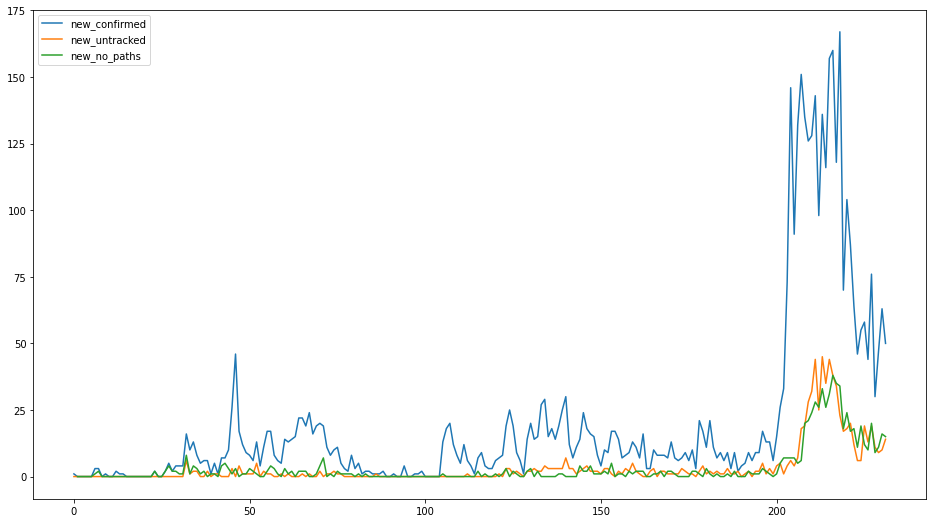

In [52]:
# 전체 그래프
df_train[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

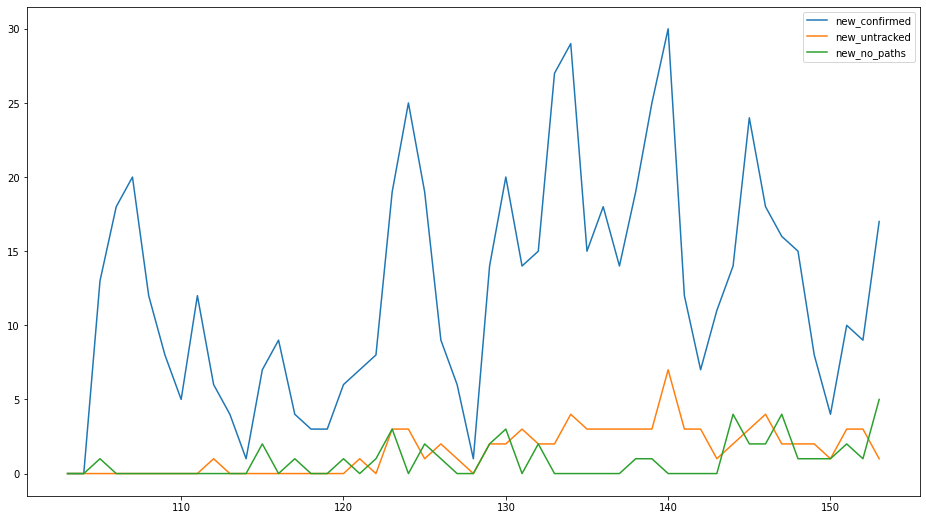

In [53]:
itaewon_crisis = df_train[(df_train["date"]>="2020-05-06") & (df_train["date"]<="2020-06-25")]
itaewon_crisis[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))


<AxesSubplot:>

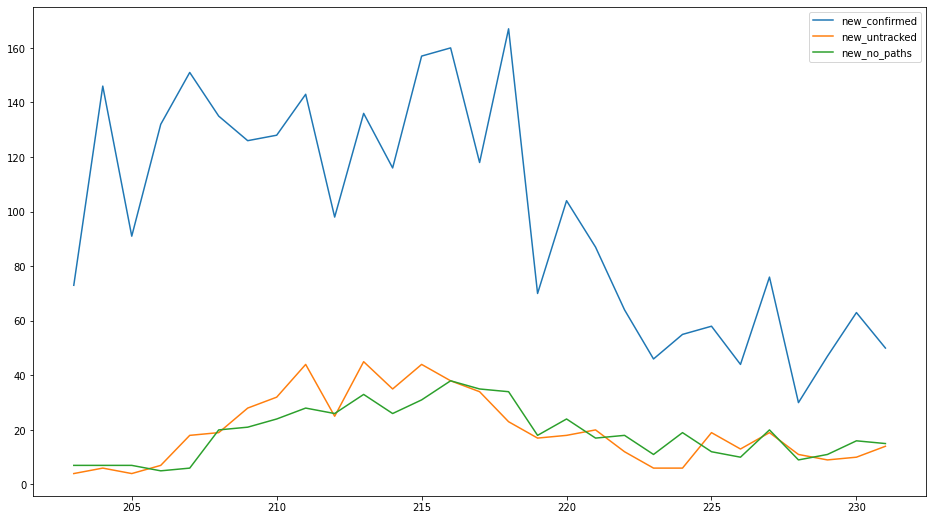

In [54]:
# 서울시 사랑제일교회 광복절 집회 이후의 데이터
jkh_crisis = df_train[(df_train["date"]>="2020-08-14")]
jkh_crisis[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

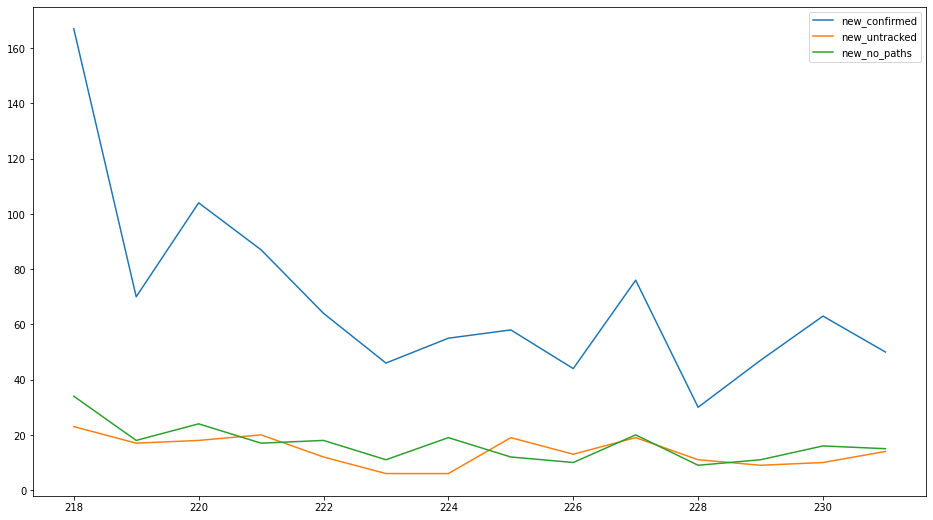

In [55]:
# 최근 2주 데이터
recent_two_weeks_data = df_train.tail(14)
recent_two_weeks_data[["new_confirmed", "new_untracked", "new_no_paths"]].plot(figsize=(16,9))

<AxesSubplot:>

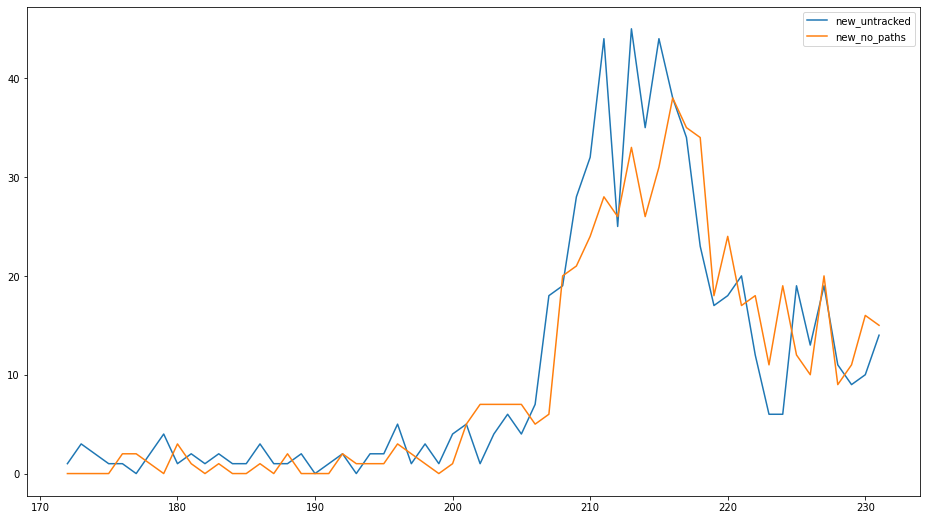

In [56]:
# 확인된 감염경로 개수와 경로 미확인 감염자 트렌드
df_train[["new_untracked", "new_no_paths"]][-60:].plot(figsize=(16,9))